Questions
- How to properly plot decision boundaries for the circular data

# ME4 Machine Learning - Tutorial 5
Lecture 5 covered some of the theory behind Support Vector Machines (SVMs). In this tutorial you will use Python and Scikit-learn to perform classification via SVMs to get practical experience of the theory covered in the lecture. You will generate some test datasets, and you will also be able to explore the different kernel types discussed in the lecture to see what effect these have on the classification performance.



First let's get some functions defined - some of these you may have seen before - these are just to help us with the rest of the tutorial:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


#define the grid to sample the domain as in previous tutorials
def gen_sample_grid(npx=200, npy=200, limit=1):
  x1line = np.linspace(-limit, limit, npx)
  x2line = np.linspace(-limit, limit, npy)
  x1grid, x2grid = np.meshgrid(x1line, x2line)
  Xgrid = np.array([x1grid, x2grid]).reshape([2,npx*npy]).T
  return Xgrid,x1line,x2line

#get a covariance matrix at an angle
def get_cov(sdx=1., sdy=1., rotangdeg=0.):
    covar = np.array([[sdx, 0], [0, sdy]])
    rot_ang = rotangdeg / 360 * 2 * np.pi
    rot_mat = np.array([[np.cos(rot_ang), -np.sin(rot_ang)], [np.sin(rot_ang), np.cos(rot_ang)]])

    covar = np.matmul(np.matmul(rot_mat, covar), rot_mat.transpose())
    return covar

#generate an xor distribution
def gen_xor_distribution(n=100):
    a = np.round(n / 4).astype('int')
    b = n-a*3
    xc1 = np.concatenate([np.random.multivariate_normal([-2.3, -2.3], get_cov(0.4, 0.1, -45), a),
                          np.random.multivariate_normal([2.3, 2.3], get_cov(0.4, 0.1, -45), a)])
    xc2 = np.concatenate([np.random.multivariate_normal([-2.3, 2.3], get_cov(0.4, 0.1, 45), a),
                          np.random.multivariate_normal([2.3, -2.3], get_cov(0.4, 0.1, 45), b)])
    xc = np.array(np.concatenate([xc1, xc2]))

    y = np.array(np.concatenate([np.zeros([2 * a, 1]), np.ones([a+b, 1])])).squeeze()
    X = xc
    return X, y

#generate a circular distribution of points
def gen_circular_distribution(n=500, scale=1):
    a = np.round(n / 7).astype('int')
    b = np.round(2*n / 7).astype('int')
    c = n - a - b
    r1 = np.concatenate(
        [np.random.normal(loc=2, scale=scale, size=[a, 1]), np.random.normal(loc=8, scale=scale, size=[c, 1])])
    r2 = np.random.normal(loc=5, scale=scale, size=[b, 1])

    th1 = np.random.uniform(low=0, high=2 * np.pi, size=[a+c, 1])
    th2 = np.random.uniform(low=0, high=2 * np.pi, size=[b, 1])

    x1a = r1 * np.cos(th1)
    x2a = r1 * np.sin(th1)

    x1b = r2 * np.cos(th2)
    x2b = r2 * np.sin(th2)

    X = np.concatenate([np.concatenate([x1a.reshape([a+c, 1]), x1b.reshape([b, 1])]),
                        np.concatenate([x2a.reshape([a+c, 1]), x2b.reshape([b, 1])])], axis=1)

    y = np.concatenate([np.zeros([a+c, 1]), np.ones([b, 1])]).squeeze()
    return X, y


#XOR dataset
We will try to perform classification on an XOR dataset (as shown in the lecture). This is a classic example which cannot be classified by a simple linear discriminator. Generate a dataset using the ‘gen_xor_distribution()’ function with a parameter of 400. Do a scatter plot to check that it looks sensible. It would be a good idea to make sure that this is producing the same dataset each time it is run, so you may wish to add ‘np.random.seed(0)’ before calling the function.

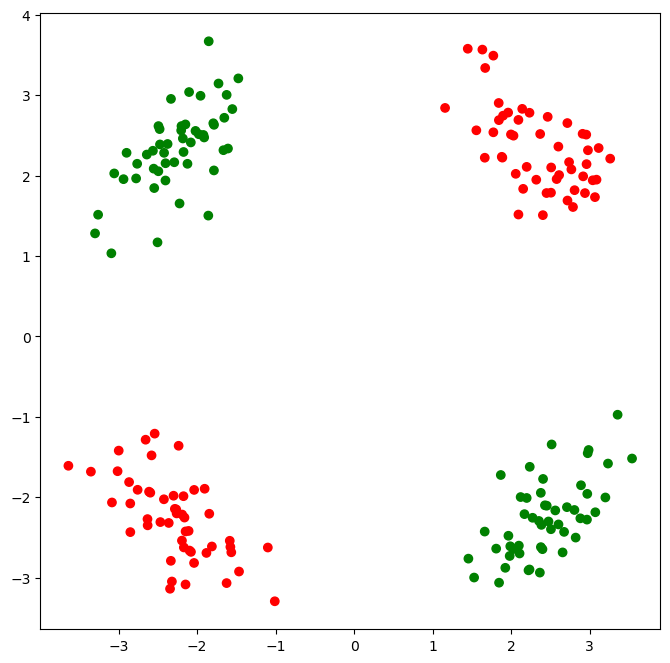

In [2]:
#Set the random seed for consistency:
np.random.seed(0)

### your code here... ###

X,y = gen_xor_distribution(200)
fig = plt.figure(figsize=(8,8))
colors=['red','green']
plt.scatter(X[:,0], X[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))

Next you can import the necessary SVM Scikit learn libraries and get them set up.

In [3]:
from sklearn.svm import SVC

#Get your SVM set up using the SVC library. 
svm = SVC(C=1, gamma='auto', kernel='rbf', degree=2)

Note that here we're using polynomial basis functions, degree 2 (matching what we did in the lecture). Use svm.fit() to fit the training XOR dataset you've just generated (note - look up the syntax in the online documentation but note that this is very similar for the scikit-learn tools) then use it to predict classification values at every point in a grid of 200 $\times$ 200 pixels from -4 to 4 in each direction - plot these. Also plot the scattered training data on top of this.

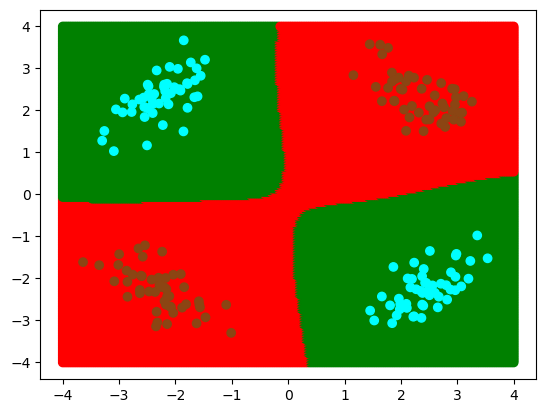

In [4]:
#name the figure as my_fig (we use this again later when we add things to the plot) - do not define a separate plot!
my_fig, ax = plt.subplots()

### your code here:
svm.fit(X,y)
Xgrid, x1line, x2line = gen_sample_grid(200,200,4)
Ypred = svm.predict(Xgrid)

colors=['red','green']
ax.scatter(Xgrid[:,0], Xgrid[:,1], c=Ypred, cmap=matplotlib.colors.ListedColormap(colors))

colors=['saddlebrown','aqua']
ax.scatter(X[:,0], X[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))

The SVC has several methods for extracting useful analysis information. SVC.decision_function() can be used to calculate the decision function throughout; its form matches the classification output from SVC.predict(), so can be plotted in exactly the same way. Plot contours at -1, 0 and 1, corresponding to the margin positions and the decision boundary itself:

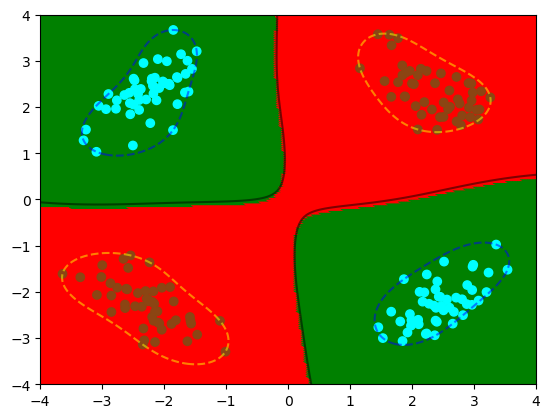

In [5]:
Z = np.reshape(svm.decision_function(Xgrid), [200, 200])
ax.contour(x1line, x2line, Z, colors=['yellow','black','blue'], levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

#this line reloads the figure
my_fig

Here, x1line and x2line are the two coordinates for which the grid is defined and Z is the decision function, reshaped to match the coordinates, Xgrid is the combination of the gridding vectors, defined via numpy.meshgrid() as in previous tutorials, and npx and npy are both 200 for the number of pixels in x and y respectively. In this plot, the two dashed lines define the extent of the margin. The solid line is the classification boundary itself. 

We now want to plot which points are the support vectors. The property sv = svm.support_vectors_ gives the support vectors. Plot these points on the scatter plot too with black crosses (marker="x", c="#000000"). 

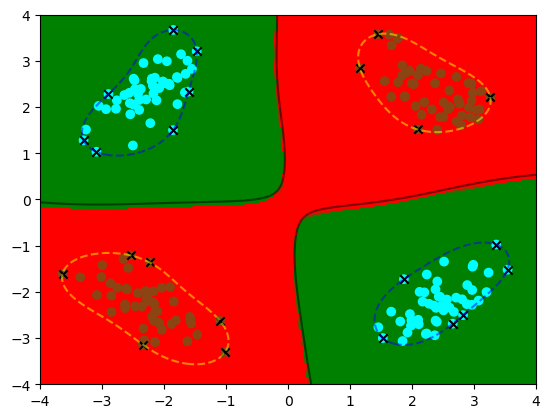

In [6]:
### your code here:

sv = svm.support_vectors_

ax.scatter(sv[:,0],sv[:,1],marker='x',color='#000000')

#reload the figure
my_fig

You should notice that several of the support vectors lie within the margin region (although in this case, none cross the boundary itself). Why do some of these points cross the margin edge? Based on what we looked at in the lecture, what could you do to stop this happening? Note that we will find out about the specific scikit-learn parameters in a minute.


 - They cross the margin edge because the classifier generalises better when they do and can tolerate these 
 - We could reduce C to prevent this from happening

---
Now try out different functions. First of all see what happens with linear mapping (kernel = 'linear') for this system. (Hint - you may find it easiest to edit the line above and rerun all cells with Ctrl+F9 rather than copying all the code.)  Does this behaviour match what you'd expect? Why? The degree=2 parameter for the polynomial kernel should be self-explanatory – try switching to a fourth-order polynomial instead. What do you think about the result? 

Then try varying C (how hard the boundary is) although note that there is a different definition here from what we discussed in the lecture - small C allows large overlaps, while large C fits the data very tightly (hard boundary) – this is the reciprocal behaviour of what we were considering. For C=1000 with kernel='poly', degree=2, you should see that there are just the support vectors needed to define the margin boundaries. This works well with well separated data, but could be more tricky if the data overlaps. 

Also try kernel='rbf' - this is a very common choice - the radial basis functions. Again, adjust the C value and see the effect on the resulting decision surface and the support vectors. 

---
# Circular dataset

In tutorial 1 you may have done the task to define a circular dataset. This is another example which is a challenge to segment via linear classifiers. The functions provided include ‘gen_circular_distribution’ which will generate the distribution for you. Use 200 points, and fit a SVM to the data. Again, try some different kernel functions and parameters to see how they perform. Note that you should plot across the range -10 to 10 in each dimension if plotting. 


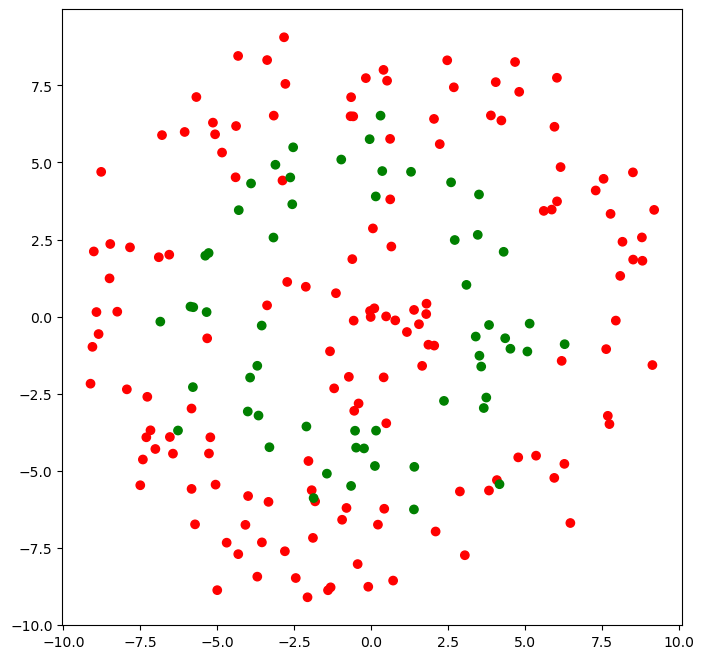

In [7]:
### your code here... ###
X,y = gen_circular_distribution(200)

fig = plt.figure(figsize=(8,8))
colors=['red','green']
plt.scatter(X[:,0], X[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))

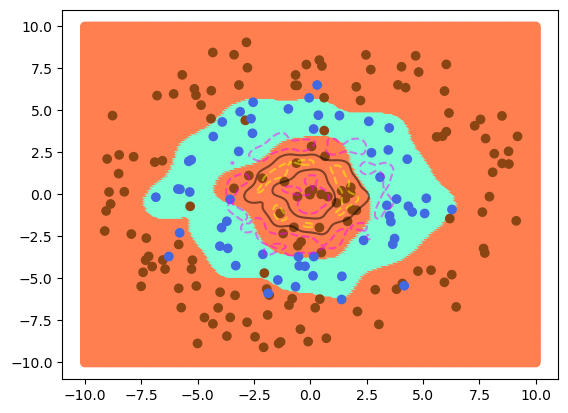

In [8]:
svm = SVC(C=1, gamma='auto', kernel='rbf')


my_fig, ax = plt.subplots()

### Fit model and predict
svm.fit(X,y)


Xgrid, x1grid, x2grid = gen_sample_grid(200,200,10)

Ypred = svm.predict(Xgrid)

# Plot predictions and original datapoints
colors=['coral','aquamarine']
ax.scatter(Xgrid[:,0], Xgrid[:,1], c=Ypred, cmap=matplotlib.colors.ListedColormap(colors))

# Original Datapoints
colors=['saddlebrown','royalblue']
ax.scatter(X[:,0], X[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))

# Decision boundaries
Z = np.reshape(svm.decision_function(Xgrid), [200, 200])
ax.contour(x1line, x2line, Z, colors=['magenta','black','yellow'], levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])



#Performance evaluation

For this part, increase the number of points in the dataset to 500. 



In [9]:
X,y = gen_circular_distribution(500)

We will now demonstrate how overfitting will behave as well as learning how to implement the k fold cross-validation approach (discussed in lecture 3).

We will use the k fold approach to test the performance for several different parameters. Scikit-learn already has tools to achieve this built in. You can set this up with:

In [10]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)

Here, n_splits defines the number of splits, and shuffle means that the data points are shuffled before being split, i.e. the points are randomly allocated to each split. 

In the following section, write code for the commented sections where indicated. Use RBF kernels for your SVMs. When you loop through to compare the data, you may wish to reuse code from one of the earlier tutorials; we did something similar in tutorial 2. You should average your five sets of performance values together. 

In [11]:
acc_list = []
for train_index, test_index in kf.split(X):
	X_train = X[train_index]
	y_train = y[train_index]
	X_test = X[test_index]
	y_test = y[test_index]

	#use X_train, y_train to train the SVM
	svm = SVC(C=100, gamma='auto', kernel='rbf')
	svm.fit(X_train,y_train)
	
  #use svm.predict() to predict the output for the test data set
	y_pred = svm.predict(X_test)
	
  #loop through to compare the test data output to what it should be 
	#	and obtain the fraction of correct classifications)
	accuracy_test =  np.sum(y_pred == y_test) / len(y_pred) 
	
  #do the same prediction and performance assessment performance 
	#	with the training data
	y_train_pred = svm.predict(X_train)
	accuracy_train = np.sum(y_train_pred == y_train) / len(y_train)
	acc_list.append([accuracy_train,accuracy_test])



In [12]:
acc_list


[[0.9775, 0.88], [0.98, 0.9], [0.97, 0.9], [0.975, 0.82], [0.99, 0.78]]

---
More detail about the code (if you are interested!)

The for loop extracts pairs of indices from the kf.split() function. We get 5 sets of these - corresponding to the number of splits identified - train_index and test_index are set to these. If you want to check the sizes of these, you should see that train_index has 80% of the indices, and test_index the remaining 20%. These indices will be different parts for each loop. We use the indices to define the training and testing datasets in the first four lines within the loop. 

Training on the training dataset should be straightforward, and predicting with the predict() function similarly. This should output a variable comparable to y_test, and you should compare each element by looping through.

The last part, assessing the performance with the training data is less necessary, however, it is useful to help judge overfitting and whether there is any discrepance between the training fitting and the performance with the test dataset.

---

Observe the results for training and testing data when C = 0.03, C = 0.2, C = 2, C = 20. What would you expect to happen to these errors as C varies? What does this mean for bias and variance?

- Higher C here means less tolerance for errors so lower bias and higher variance

If you have time and want to investigate more, you can try to plot a graph as a function of C. In order to investigate the behaviour of the performance for both the training and testing data fully, you can add another loop around the outside of this to vary C automatically; it is wise to use a power law to sample, e.g.:

In [13]:
C_array = np.power(10, np.linspace(-1.5, 1.5, 8))

This will generate eight of values between $10^{-1.5}$ and $10^{1.5}$. Produce a plot of the two values as a function of C. 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

test_acc = []
train_acc = []

for c in C_array:
    svm = SVC(C=c, gamma='auto', kernel='rbf')
    svm.fit(X_train,y_train)
    y_test_pred = svm.predict(X_test)
    y_train_pred = svm.predict(X_train)
    test_acc.append(accuracy_score(y_test,y_test_pred))
    train_acc.append(accuracy_score(y_train,y_train_pred))
    

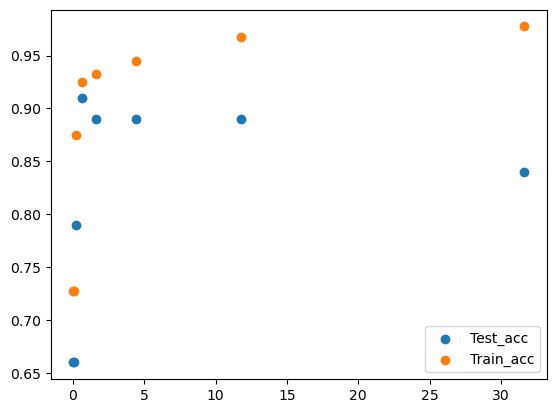

In [15]:
plt.scatter(C_array,test_acc,label = "Test_acc")
plt.scatter(C_array,train_acc,label = "Train_acc")
plt.legend()

Does this match your expectation? Based on this, what would you set your value of C to be? Identify where bias and variance would be high and low respectively.

- Matches my expectaition. As C increases training accurayc increases and testing acuracy decreseas. I would set C at about 2.5